# SIGN Recognizer

In this notebook we will implement a convolutional neural network in TensorFlow to recognize images from the SIGN dataset, which is comprised of hand gestures images that represent numbers from 0 to 5.

## Preliminaries

Let's import the libraries we will use.

In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from helpers import *

%matplotlib inline
np.random.seed(1)

## Loading Dataset

Let's proceed to load the dataset:

In [2]:
X_train, y_train, X_test, y_test, classes = load_dataset()

Let's now take a look at some of our instances:

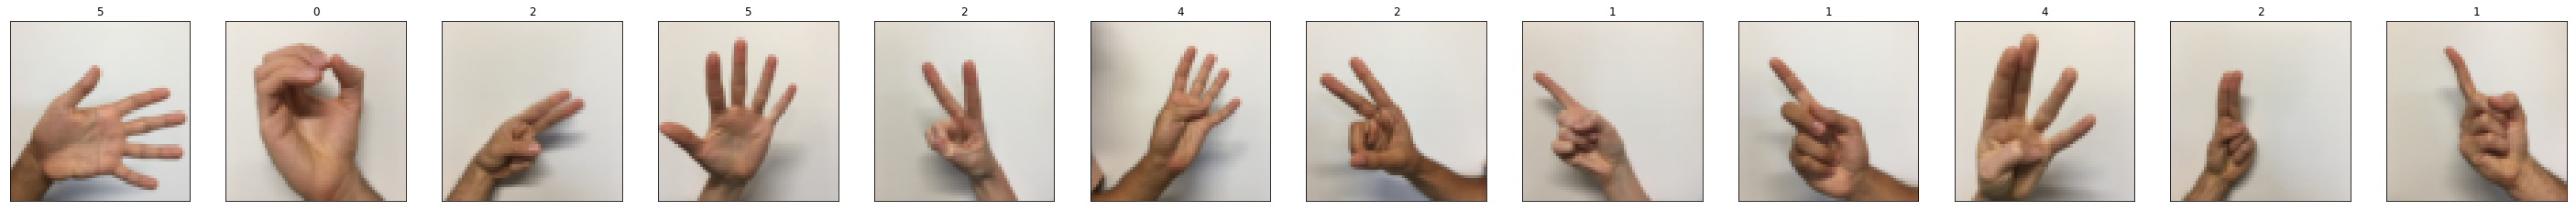

In [3]:
SAMPLE_SIZE = 12

# Plot the images in the sample
figure = plt.figure(figsize=(50, 50))

for sample_index in range(SAMPLE_SIZE):
    ax = figure.add_subplot(1, SAMPLE_SIZE, sample_index + 1, xticks=[], yticks=[])
    ax.imshow(X_train[sample_index])
    ax.set_title(np.squeeze(y_train[:, sample_index]))

## Preprocess Data

Good. Let's preprocess our examples by normalizing them (we'll divide each pixel by 255) and our labels by one-hot encoding them:

In [4]:
X_train = X_train / 255.0
X_test = X_test / 255.0

NUMBER_OF_CLASSES = 6
y_train = one_hot_encode(y_train, NUMBER_OF_CLASSES).T
y_test = one_hot_encode(y_test, NUMBER_OF_CLASSES).T

Let's print some general information about the dataset:

In [5]:
print(f'Number of training examples: {len(X_train)}')
print(f'Number of test examples: {len(X_test)}')
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

Number of training examples: 1080
Number of test examples: 120
X_train shape: (1080, 64, 64, 3)
y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
y_test shape: (120, 6)


## Creating placeholders

TensorFlow needs that we create placeholders for the data that will be processed by the model. 

Let's implement a function to do this:

In [6]:
def create_placeholders(input_height, input_width, input_channels, number_of_classes):
    X = tf.placeholder(tf.float32, shape=(None, input_height, input_width, input_channels))
    y = tf.placeholder(tf.float32, shape=(None, number_of_classes))
    
    return X, y

We can test this function as follows:

In [7]:
X, y = create_placeholders(64, 64, 3, 6)

print(f'X: {X}')
print(f'y: {y}')

X: Tensor("Placeholder:0", shape=(?, 64, 64, 3), dtype=float32)
y: Tensor("Placeholder_1:0", shape=(?, 6), dtype=float32)


## Parameters Initialization

Given we are building a two-layered CNN, we need a way to initialize the two weight matrices our model will use.

In [8]:
def initialize_parameters(w1_shape=(4, 4, 3, 8), w2_shape=(2, 2, 8, 16)):
    tf.set_random_seed(1)
    
    w1 = tf.get_variable('W1', w1_shape, initializer=tf.contrib.layers.xavier_initializer(seed=0))
    w2 = tf.get_variable('W2', w2_shape, initializer=tf.contrib.layers.xavier_initializer(seed=0))
    
    return {'W1': w1, 'W2': w2}
    

Testing this function is a bit more cumbersome:

In [9]:
tf.reset_default_graph()

with tf.Session() as s:
    parameters = initialize_parameters()
    
    initializer = tf.global_variables_initializer()
    
    s.run(initializer)
    
    print(f'W1: {parameters["W1"].eval()[1, 1, 1]}')
    print(f'W2: {parameters["W2"].eval()[1, 1, 1]}')

W1: [ 0.00131723  0.1417614  -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
W2: [-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]


## Forward Propagation

We will implement the following architecture: `CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED`. We'll rely on the functions defined before. 

In detail, we will use the following parameters for all the steps:
     - Conv2D: stride 1, padding is "SAME"
     - ReLU
     - Max pool: Use an 8 by 8 filter size and an 8 by 8 stride, padding is "SAME"
     - Conv2D: stride 1, padding is "SAME"
     - ReLU
     - Max pool: Use a 4 by 4 filter size and a 4 by 4 stride, padding is "SAME"
     - Flatten the previous output.
     - FULLYCONNECTED (FC) layer: Apply a fully connected layer without an non-linear activation function. We won't call the softmax here. This will result in 6 neurons in the output layer, which then get passed later to a softmax. In TensorFlow, the softmax and cost function are lumped together into a single function, which we'll call in a different function when computing the cost. 

In [10]:
def forward_propagation(X, parameters):
    # Unpack relevant parameters
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # Conv2D: stride 1, padding is "SAME"
    out = tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='SAME')
    # RELU
    out = tf.nn.relu(out)
    # Max pool: Use an 8 by 8 filter size and an 8 by 8 stride, padding is "SAME"
    out = tf.nn.max_pool(out, ksize=[1, 8, 8, 1], strides=[1, 8, 8, 1], padding='SAME')
    
    # Conv2D: stride 1, padding is "SAME"
    out = tf.nn.conv2d(out, W2, strides=[1, 1, 1, 1], padding='SAME')
    # RELU
    out = tf.nn.relu(out)
    # Max pool: Use a 4 by 4 filter size and a 4 by 4 stride, padding is "SAME"
    out = tf.nn.max_pool(out, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1], padding='SAME')
    
    # Flatten
    out = tf.contrib.layers.flatten(out)

    # Fully-connected
    out = tf.contrib.layers.fully_connected(out, NUMBER_OF_CLASSES, activation_fn=None)
    return out

Another tricky test run is ahead:

In [11]:
tf.reset_default_graph()

with tf.Session() as s:
    np.random.seed(1)
    
    X, y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    fp = forward_propagation(X, parameters)
    
    initializer = tf.global_variables_initializer()
    
    s.run(initializer)
    
    result = s.run(fp, {X: np.random.randn(2, 64, 64, 3), y: np.random.randn(2, 6)})
    
    print(f'Result: {result}')

Result: [[ 1.4416983  -0.24909672  5.4504995  -0.26189643 -0.20669863  1.3654673 ]
 [ 1.407085   -0.02573237  5.08928    -0.48669893 -0.40940693  1.2624853 ]]


## Computing Cost

In [12]:
def compute_cost(logits, labels):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))

Let's test our cost function:

In [13]:
tf.reset_default_graph()

with tf.Session() as s:
    np.random.seed(1)
    
    X, y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    
    fp = forward_propagation(X, parameters)
    cost = compute_cost(fp, y)

    initializer = tf.global_variables_initializer() 
    s.run(initializer)

    result = s.run(cost, {X: np.random.randn(4, 64, 64, 3), y: np.random.randn(4, 6)})
    
    print(f'Result: {result}')

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Result: 4.664870738983154


## Model

Let's use all the helper functions we have defined so far to implement and train the model.

In [14]:
def model(X_train, y_train, 
          learning_rate=0.009, epochs=200, mini_batch_size=64, print_cost=True):
    ops.reset_default_graph()
    tf.set_random_seed(1)
    
    seed = 3
    
    (number_of_training_examples, input_height, input_width, input_channels) = X_train.shape
    number_of_labels = y_train.shape[1]
    costs = []
    
    X, y = create_placeholders(input_height, input_width, input_channels, number_of_labels)
    parameters = initialize_parameters()
    
    fp = forward_propagation(X_train.astype(np.float32), parameters)
    
    cost = compute_cost(fp, y_train.astype(np.float32))
    
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    initializer = tf.global_variables_initializer()
    
    with tf.Session() as s:
        s.run(initializer)
        
        for epoch in range(epochs):
            mini_batch_cost = 0.0
            number_of_mini_batches = int(number_of_training_examples / mini_batch_size)
            seed += 1
            mini_batches = random_mini_batches(X_train, y_train, mini_batch_size, seed)
            
            for mini_batch in mini_batches:
                (mini_batch_X, mini_batch_y) = mini_batch
                
                _, temp_cost = s.run([optimizer, cost], feed_dict={X: mini_batch_X, y: mini_batch_y})
                
                mini_batch_cost += temp_cost / number_of_mini_batches
                
            if print_cost:
                costs.append(mini_batch_cost)
                
                if epoch % 5 == 0:
                    print(f'Cost after epoch {epoch}: {mini_batch_cost}')
                    
        # Plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iteration x 10')
        plt.title(f'Learning rate: {learning_rate}')
        plt.show()
        
        # Calculate the correct predictions
        predict_op = tf.argmax(fp, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(y, 1))
        
        # Calculate accuracy on the training set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
        print(f'Accuracy: {accuracy}')
        
        train_accuracy = accuracy.eval({X: X_train, y: y_train})
        print(f'Train accuracy: {train_accuracy}')
        
        return train_accuracy, parameters
                

Cost after epoch 0: 1.9281534105539322
Cost after epoch 5: 1.8232299461960793
Cost after epoch 10: 1.249977596104145
Cost after epoch 15: 0.749159075319767
Cost after epoch 20: 0.5282769743353128
Cost after epoch 25: 0.3954030014574528
Cost after epoch 30: 0.3060926180332899
Cost after epoch 35: 0.24129029270261526
Cost after epoch 40: 0.1937517886981368
Cost after epoch 45: 0.1558464616537094
Cost after epoch 50: 0.1273683630861342
Cost after epoch 55: 0.10443088132888079
Cost after epoch 60: 0.08691564574837685
Cost after epoch 65: 0.07292873552069068
Cost after epoch 70: 0.061586166732013226
Cost after epoch 75: 0.05224526789970696


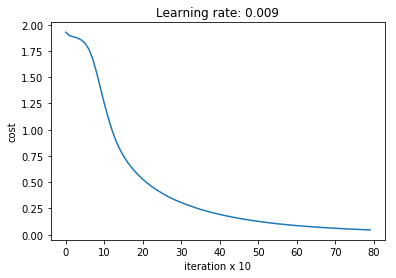

Accuracy: Tensor("Mean_1:0", shape=(), dtype=float32)
Train accuracy: 0.9981481432914734


In [15]:
_, parameters = model(X_train, y_train, epochs=80)

Good, we trained a simple model to recognize numbers in hand gestures using TensorFlow. 

Despite its power and uncontestable popularity, TensorFlow is quite more verbose and complex than Keras. However, it's worth being fluent in both frameworks.